# Индивидуальный проект. (Кузнецов Александр Юрьевич)

# 1.Описание набора данных и признаков.

Данный проект кредитного скоринга решает задачу предсказания вероятности успешного возврата кредита для каждого заёмщика.

В анализе будут участвовать два набора данных длиной порядка 100-150 тысяч строк: исторические данные (на которых будет обучаться модель) и эталонные данные (на которых будет применена модель). 

Ссылка на данные https://github.com/alexander15555/alexander155
    
Название переменной - описание (тип переменной):

1.SeriousDlqin2yrs - наблюдалась просрочка в размере 90 и более дней (Категориальная) - ЦЕЛЕВАЯ ПЕРЕМЕННАЯ

2.RevolvingUtilizationOfUnsecuredLines - общий баланс по кредитным картам и личным кредитам (Процентный)

3.Age - возраст заёмщика (целочисленный)

4.NumberOfTime30-59DaysPastDueNotWorse - количество просрочек за последние 2 года от 30 до 59 дней (Целочисленный)

5.DebtRatio - ежемесячные платежи по долгам, деленные на валовой доход в месяц (Процентный)

6.MonthlyIncome - ежемесячный доход (Целочисленный)

7.NumberOfOpenCreditLinesAndLoans	- количество открытых кредитов и кредитных карт (Целочисленный)

8.NumberOfTimes90DaysLate	- количество просрочек от 90 дней и более (Целочисленный)

9.NumberRealEstateLoansOrLines - количество ипотечных кредитов и кредитов на недвижимость (Целочисленный)

10.NumberOfTime60-89DaysPastDueNotWorse - количество просрочек за последние 2 года от 60 до 89 дней (Целочисленный)

11.NumberOfDependents - количество иждивенцев в семье, исключая себя (Целочисленный) 


С целью построения модели кредитного скоринга определяется зависимая переменная категориального типа. Это «SeriousDlqin2yrs» –  признак просроченной задолженности на 90 и более дней. В качестве независимых переменных предстают все остальные атрибуты.



# 2.Первичный анализ данных.

In [228]:
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import pylab as pl
from matplotlib import pyplot
%matplotlib inline

In [229]:
train = pd.read_csv('creditscore-train.csv', sep=',', encoding='cp1251')

In [230]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [231]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


In [232]:
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Пустые значения были обнаружены по двум атрибутам: MonthlyIncome «ежемесячный доход» и NumberOfDependents «количество иждивенцев».

In [233]:
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(), inplace = True)
train['NumberOfDependents'].fillna(0, inplace = True)

Заменим пропущенные значения по доходу на среднее по данному признаку. 
Заменим пропущенные значения по количеству иждивенцев на нулевое значение, поскольку более вероятно, что клиент не заполнил данное поле по причине отсутствия семьи.

In [234]:
train['age'].max()

109

Видим что в данных имеются "выбросы" - некорректные значения сильно отклоняющиеся от средних величин.

In [235]:
train = train.drop('Unnamed: 0', axis = 1)
train = train.rename(columns = {'NumberOfTime30-59DaysPastDueNotWorse' : 'NumberOfTime3059DaysPastDueNotWorse'})
train = train.rename(columns = {'NumberOfTime60-89DaysPastDueNotWorse': 'NumberOfTime6089DaysPastDueNotWorse'})
train1 = train['SeriousDlqin2yrs']
train1 = pd.DataFrame(train1)
train2 = train.drop('SeriousDlqin2yrs', axis = 1)

In [236]:
RevolvingUtilizationOfUnsecuredLines = train2['RevolvingUtilizationOfUnsecuredLines']
age = train2['age']
NumberOfTime3059DaysPastDueNotWorse = train2['NumberOfTime3059DaysPastDueNotWorse']
DebtRatio = train2['DebtRatio']
MonthlyIncome = train2['MonthlyIncome']
NumberOfOpenCreditLinesAndLoans = train2['NumberOfOpenCreditLinesAndLoans']
NumberOfTimes90DaysLate = train2['NumberOfTimes90DaysLate']
NumberRealEstateLoansOrLines = train2['NumberRealEstateLoansOrLines']
NumberOfTime6089DaysPastDueNotWorse = train2['NumberOfTime6089DaysPastDueNotWorse']
NumberOfDependents = train2['NumberOfDependents']

In [237]:
a = [RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime3059DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime6089DaysPastDueNotWorse, NumberOfDependents]

В случае с «выбросами» использовалось правило трёх сигм. Следуя ему, вероятность того, что случайная величина отклонится от своего математического ожидания на большую величину, чем утроенное среднее квадратичное отклонение, практически равна нулю. 

In [238]:
def outlier(col):
    col[(col < (col.mean() - 3 * col.std())) | (col > (col.mean() + 3 * col.std()))] = col.mean()
    return col  

In [239]:
b = []
for par in a:
    b.append(outlier(par))

In [240]:
data = pd.DataFrame(b)
data = data.T

# 3 и 4.Первичный визуальный анализ данных и Инсайты, найденные зависимости.

Значения по каждому атрибуту исследуемого дата-сета, которые выходят за рамки, установленные вышеупомянутым правилом, были заменены на среднее по своему признаку. Ниже визуальное представление данных.

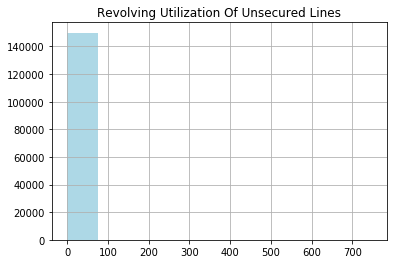

In [248]:
plot1 = data['RevolvingUtilizationOfUnsecuredLines'].hist(color = 'lightblue')
plot1.set_title("Revolving Utilization Of Unsecured Lines")
pl.show()

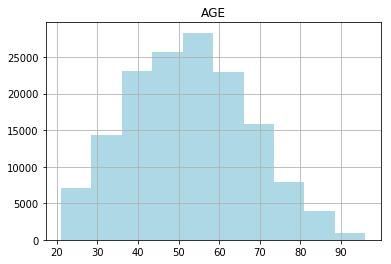

In [249]:
plot1 = data['age'].hist(color = 'lightblue')
plot1.set_title("AGE")
pl.show()

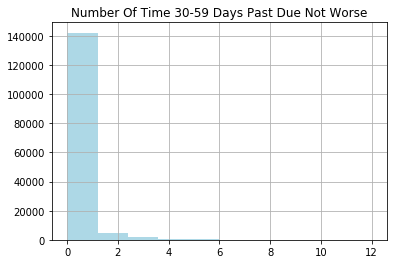

In [250]:
plot1 = data['NumberOfTime3059DaysPastDueNotWorse'].hist(color = 'lightblue')
plot1.set_title("Number Of Time 30-59 Days Past Due Not Worse")
pl.show()

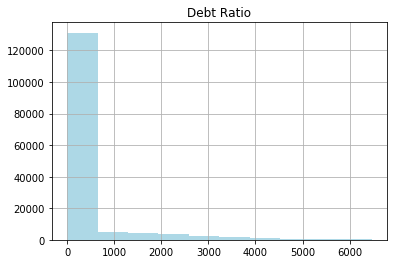

In [251]:
plot1 = data['DebtRatio'].hist(color = 'lightblue')
plot1.set_title("Debt Ratio")
pl.show()

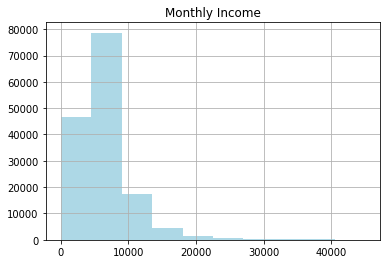

In [252]:
plot1 = data['MonthlyIncome'].hist(color = 'lightblue')
plot1.set_title("Monthly Income")
pl.show()

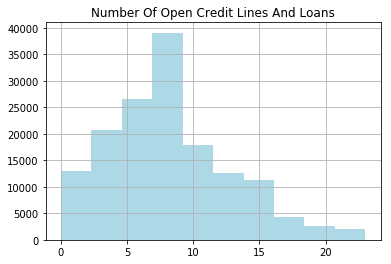

In [253]:
plot1 = data['NumberOfOpenCreditLinesAndLoans'].hist(color = 'lightblue')
plot1.set_title("Number Of Open Credit Lines And Loans")
pl.show()

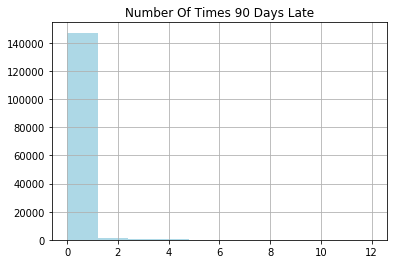

In [254]:
plot1 = data['NumberOfTimes90DaysLate'].hist(color = 'lightblue')
plot1.set_title("Number Of Times 90 Days Late")
pl.show()

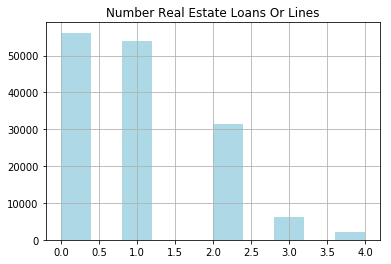

In [255]:
plot1 = data['NumberRealEstateLoansOrLines'].hist(color = 'lightblue')
plot1.set_title("Number Real Estate Loans Or Lines")
pl.show()

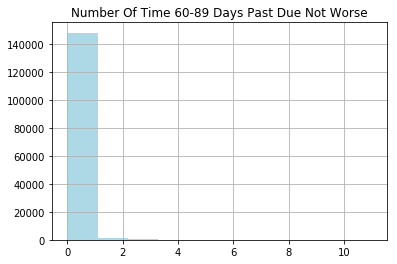

In [256]:
plot1 = data['NumberOfTime6089DaysPastDueNotWorse'].hist(color = 'lightblue')
plot1.set_title("Number Of Time 60-89 Days Past Due Not Worse")
pl.show()

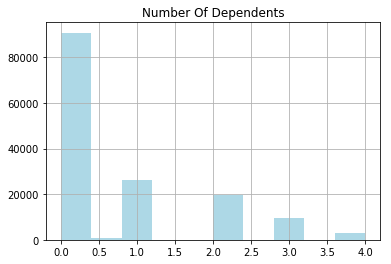

In [257]:
plot1 = data['NumberOfDependents'].hist(color = 'lightblue')
plot1.set_title("Number Of Dependents")
pl.show()

Резкие "выбросы" в данных не наблюдаются.Средний возраст заемщиков около 55 лет.

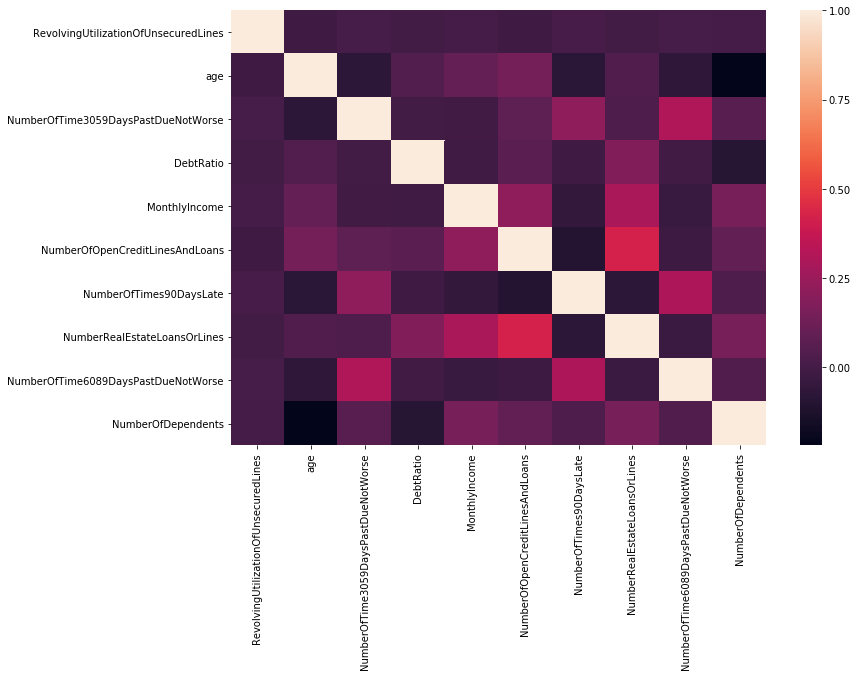

In [258]:
cols = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime3059DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime6089DaysPastDueNotWorse',
       'NumberOfDependents']
a4_dims = (12, 8)
df = data[cols].corr()
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df)

Наблюдается корреляция между признаками "NumberRealEstateLoansOrLines" (Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии собственного капитала) и "NumberOfOpenCreditLinesAndLoans" (Количество открытых кредитов и кредитных карт).

Также наблюдаетcя более слабая корреляция между признаками:
1. "NumberOfTimes90DaysLate" (количество просрочек от 90 дней и более) и "NumberOfTime6089DaysPastDueNotWorse" (количество просрочек за последние 2 года от 60 до 89 дней).
2. "NumberOfTime6089DaysPastDueNotWorse" (количество просрочек за последние 2 года от 60 до 89 дней) и "NumberOfTime3059DaysPastDueNotWorse" (Количество просрочек за последние 2 года от 30 до 59 дней)
3. "NumberRealEstateLoansOrLines" (Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии собственного капитала) и "MonthlyIncome" (Ежемесячный доход).

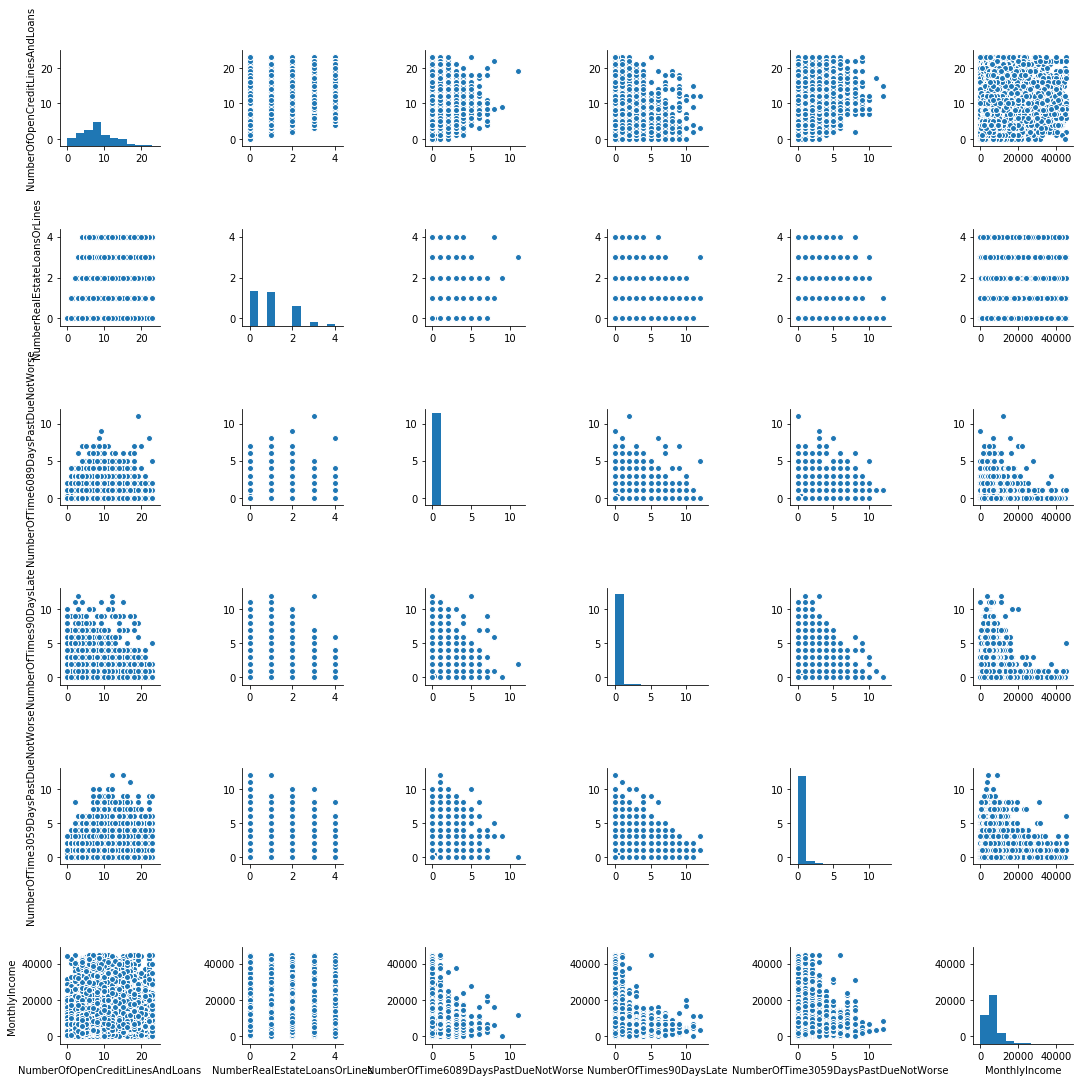

In [259]:
sns.pairplot(data[['NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines',
                   'NumberOfTime6089DaysPastDueNotWorse','NumberOfTimes90DaysLate',
                   'NumberOfTime3059DaysPastDueNotWorse','MonthlyIncome']])

# 5. Выбор метрики

В качестве основной метрики для оценки качества модели будет выбран критерий ROC-AUC. Метрика ROC AUC зависит не от строгой дискретной классификации,а от предсказанных вероятностей классов, поэтому она более применима к задаче такого типа. При этом она подходит для несбалансированных данных.

ROC-кривая – это графическая характеристика качества бинарного классификатора, отражает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров. AUC является количественным показателем ROC: это площадь, ограниченная осями и ROC-кривой.



# 6. Выбор модели

Выбор модели - логистическая регрессия. 

Простой и быстрый вариант.Логистическая регрессия выдает вероятности отнесения к разным классам (это очень ценится в кредитном скоринге). Также логистическая регрессия хорошо интерпретируема и используется в реальном банковском моделировании рисков. 

# 7. Предобработка данных

Предобработка данных для данной работы была проведена в пунктах ранее.

Первичная обработка данных представляет из себя замену пустых значений и избавление от «выбросов». Пустые значения на данных для обучения были обнаружены по двум атрибутам: «ежемесячный доход» и «количество иждивенцев». Было принято решение заменить пропущенные значения по доходу на среднее по данному признаку. А по количеству иждивенцев – на нулевое значение, поскольку более вероятно, что клиент не заполнил данное поле по причине отсутствия семьи. В случае с «выбросами» использовалось правило трёх сигм. Следуя ему, вероятность того, что случайная величина отклонится от своего математического ожидания на большую величину, чем утроенное среднее квадратичное отклонение, практически равна нулю.

# 8,9,10. Кросс-валидация и настройка гиперпараметров модели, создание новых признаков и описание этого процесса, построение кривых валидации и обучения

In [260]:
X = data
Y = train1

In [261]:
X.shape

(150000, 10)

In [262]:
Y.shape

(150000, 1)

In [263]:
kf = KFold(n=150000, n_folds=5, shuffle=True)

Используемые для формирования модели информационные данные являются исторической выборкой, которая наиболее точно отображает генеральную совокупность исследуемых людей. Её разбиение проводилось при помощи техники кросс-валидации по 5 блокам с использованием генератора разбиений KFold.

Предобработка данных и признаков производилась в пункта ранее.

In [264]:
def my_scorer(estimator, testX, testY):
    predicted_testY = estimator.predict_proba(testX)[:, 1]
    return roc_auc_score(testY, predicted_testY)

In [265]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

Перед разбиением производилось случайное перемешивание объектов выборки, чтобы избежать смещённости кросс-валидационной оценки. Реализация логистической регрессии показала, что наибольшая AUC-ROC величина наблюдалась при значении свободного члена С = 0,0001. 

In [266]:
def LogR_teach(C_value):
    clf = LogisticRegression(penalty='l2', C=C_value)
    return cross_val_score(clf, scaledX, Y, cv=kf, scoring=my_scorer).mean()

In [267]:
def C_variants():
    for power in range(-4, 2):
        C = math.pow(10, power)
        quality = LogR_teach(C)
        print ('C=', C, ', quality=', quality)

In [268]:
C_variants()

C= 0.0001 , quality= 0.817094938003
C= 0.001 , quality= 0.815788923436
C= 0.01 , quality= 0.81255987371
C= 0.1 , quality= 0.811882964676
C= 1.0 , quality= 0.81180761489
C= 10.0 , quality= 0.811800093206


In [269]:
X_train, X_test, y_train, y_test = train_test_split(scaledX, Y, test_size=.2, random_state=0)
clf = LogisticRegression(penalty='l2', C=0.0001)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:, 1]

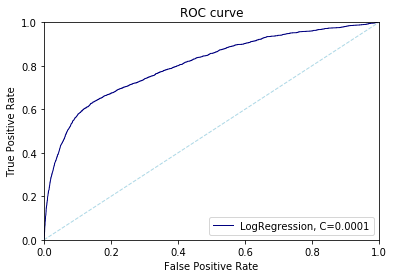

In [271]:
plt.figure()
line_width = 1
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color='navy', lw=line_width, label='LogRegression, C=0.0001')
plt.plot([0, 1], [0, 1], color='lightblue', lw=line_width, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Показателем качества модели является величина площади под ROC-кривой 0,817.

# 11. Прогноз для тестовой или отложенной выборки

Приведем отложенный датасет к надлежащему виду, повторив все преобразования. Затем применим логистическую регрессию и вычислим предсказания на тестовом дата-сете.

In [272]:
test = pd.read_csv('creditscore-test.csv', sep=',', encoding='cp1251')

In [273]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              101503 non-null int64
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(7)
memory usage: 9.3 MB


In [274]:
test.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

Пустые значения были обнаружены по двум атрибутам: MonthlyIncome «ежемесячный доход» и NumberOfDependents «количество иждивенцев».

In [275]:
test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(), inplace = True)
test['NumberOfDependents'].fillna(0, inplace = True)

Заменим пропущенные значения по доходу на среднее по данному признаку. Заменим пропущенные значения по количеству иждивенцев на нулевое значение, поскольку более вероятно, что клиент не заполнил данное поле по причине отсутствия семьи.

In [276]:
del test['Unnamed: 0']
del test['SeriousDlqin2yrs']

In [277]:
test = test.rename(columns = {'NumberOfTime30-59DaysPastDueNotWorse' : 'NumberOfTime3059DaysPastDueNotWorse'})
test = test.rename(columns = {'NumberOfTime60-89DaysPastDueNotWorse': 'NumberOfTime6089DaysPastDueNotWorse'})

In [278]:
RevolvingUtilizationOfUnsecuredLines = test['RevolvingUtilizationOfUnsecuredLines']
age = test['age']
NumberOfTime3059DaysPastDueNotWorse = test['NumberOfTime3059DaysPastDueNotWorse']
DebtRatio = test['DebtRatio']
MonthlyIncome = test['MonthlyIncome']
NumberOfOpenCreditLinesAndLoans = test['NumberOfOpenCreditLinesAndLoans']
NumberOfTimes90DaysLate = test['NumberOfTimes90DaysLate']
NumberRealEstateLoansOrLines = test['NumberRealEstateLoansOrLines']
NumberOfTime6089DaysPastDueNotWorse = test['NumberOfTime6089DaysPastDueNotWorse']
NumberOfDependents = test['NumberOfDependents']

In [279]:
c = [RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime3059DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime6089DaysPastDueNotWorse, NumberOfDependents]

In [280]:
d = []
for par in c:
    d.append(outlier(par))

In [281]:
test_ = pd.DataFrame(d)
test_ = test_.T

In [282]:
test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43.0,0.0,0.177513,5700.0,4.0,0.0,0.0,0.0,0.0
1,0.463295,57.0,0.0,0.527237,9141.0,15.0,0.0,4.0,0.0,2.0
2,0.043275,59.0,0.0,0.687648,5083.0,12.0,0.0,1.0,0.0,2.0
3,0.280308,38.0,1.0,0.925961,3200.0,7.0,0.0,2.0,0.0,0.0
4,1.000000,27.0,0.0,0.019917,3865.0,4.0,0.0,0.0,0.0,1.0


In [283]:
scaled_test = scaler.transform(test_)

In [284]:
clf = LogisticRegression(penalty='l2', C=0.0001)
clf.fit(scaledX, Y)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Применяется модель логистической регрессии с наиболее подходящим коэффициентом С = 0,0001.

In [285]:
prediction = clf.predict_proba(scaled_test)[:, 1]

In [286]:
min(prediction), max(prediction)

(0.059255560645439208, 0.99725882088590911)

In [287]:
result = pd.DataFrame(np.array(prediction), columns=['probability'], index=test_.index)

In [288]:
result[result['probability']>0.5].count()

probability    1629
dtype: int64

In [289]:
result.count()

probability    101503
dtype: int64

Тоесть доля заёмщиков, у которых предсказанная вероятность больше 0,5 составляет чуть более 1,5 % от общего количества людей в тестовой выборке. 

In [290]:
result

,probability
0,0.157626
1,0.139810
2,0.147162
3,0.202525
4,0.177543
5,0.145783
6,0.165250
7,0.167244
8,0.131186
9,0.252834


# 12. Выводы

Была построена модель для кредитного скоринга, которая решает задачу предсказания вероятности успешного возврата кредита для каждого заёмщика.

На исторических данных полученное качество модели, оцененное с поомщью метрики ROC-AUС составляет 0.817, что говорит о хорошей предсказательной способности модели.

На тестовой выборке были получены предсказанные вероятности, определяющие кредитоспособность клиентов. Доля заёмщиков, у которых предсказанная вероятность больше 0,5 составляет чуть более 1,5 % от общего количества людей в тестовой выборке.

Улучшить модель возможно, если:
1.более точно отбрать важные для модели признаки
2.использовать дополнительно внешние данные
3.определить ошибки алгоритма и скорректировать модель.